In [1]:
import sys
sys.version
!lscpu

Architecture:        ppc64le
Byte Order:          Little Endian
CPU(s):              128
On-line CPU(s) list: 0-127
Thread(s) per core:  4
Core(s) per socket:  16
Socket(s):           2
NUMA node(s):        6
Model:               2.3 (pvr 004e 1203)
Model name:          POWER9, altivec supported
CPU max MHz:         3800.0000
CPU min MHz:         2300.0000
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            10240K
NUMA node0 CPU(s):   0-63
NUMA node8 CPU(s):   64-127
NUMA node252 CPU(s): 
NUMA node253 CPU(s): 
NUMA node254 CPU(s): 
NUMA node255 CPU(s): 


In [2]:
import numpy
from ctypes import *
import time
from math import ceil
from collections import OrderedDict, namedtuple
Result = namedtuple("Res", "flux reflux")
%matplotlib nbagg
from matplotlib.pylab import subplots

In [3]:
ls

Benchmark_bitshuffle.ipynb  debug2.py*       libblosc2.so.2.0.0*
CMakeFiles/                 libblosc2.a      libblosc_testing.so*
cmake_install.cmake         libblosc2.so@    Makefile
config.h                    libblosc2.so.2@  shuffle.svg


In [4]:
blosc2 = cdll.LoadLibrary("build_dev/blosc/libblosc2.so.2.0.0")

In [5]:
size = 1024
dtype = numpy.dtype("int32")
inp = numpy.random.randint(1<<31, size=size).astype(dtype)
out = numpy.empty_like(inp)
print(inp, out)

[1917101119  451258668 1012210582 ...  135704861  667943694 1045308881] [-1397222064       32767 -1397222064 ...           0   418376390
           0]


In [6]:
def shuffle(inp, out=None):
    if out is None:
        out = numpy.empty_like(inp)
    type_size = c_int32(numpy.dtype(inp.dtype).itemsize)
    blocksize = c_int32(inp.nbytes)
    blosc2.shuffle(type_size, blocksize, inp.ctypes.data, out.ctypes.data)
    return out
def unshuffle(inp, out=None):
    if out is None:
        out = numpy.empty_like(inp)
    type_size = c_int32(numpy.dtype(inp.dtype).itemsize)
    blocksize = c_int32(inp.nbytes)
    blosc2.unshuffle(type_size, blocksize, inp.ctypes.data, out.ctypes.data)
    return out
assert abs(unshuffle(shuffle(inp))-inp).sum() == 0

In [7]:
%timeit shuffle(inp, out)

10000 loops, best of 5: 39.3 µs per loop


In [9]:
def benchmark(sflux="shuffle_sse2", sreflux= "unshuffle_sse2",
              dtype="int32", minsize=10, maxsize=25):
    print("Benchmarking %s and %s"%(sflux, sreflux))
    flux = blosc2.__getattr__(sflux)
    reflux = blosc2.__getattr__(sreflux)
    type_size = c_int32(numpy.dtype(dtype).itemsize)
    globals()["flux"] = flux
    globals()["reflux"] = reflux
    globals()["type_size"] = type_size
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    if dtype.kind=="i":
        maxi = 1<<(dtype.itemsize*8-2)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        if dtype.kind=="i":
            inp = numpy.random.randint(maxi, size=size//dtype.itemsize).astype(dtype)
        else:
            inp = numpy.random.random(size=size//dtype.itemsize).astype(dtype)
        tmp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        
        blocksize = c_int32(inp.nbytes)
        flux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        reflux(type_size, blocksize, tmp.ctypes.data, out.ctypes.data)
        assert abs(out-inp).sum() == 0
        
        globals()["blocksize"] = blocksize
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["out"] = out
        b = %timeit -o flux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        u = %timeit -o reflux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [9]:
results_shuffle_generic = benchmark("shuffle_generic", "unshuffle_generic", maxsize=25)
results_shuffle_sse2 = benchmark("shuffle_altivec", "unshuffle_altivec", maxsize=25)

Benchmarking shuffle_generic and unshuffle_generic
1k 1024
10000 loops, best of 5: 38.2 µs per loop
10000 loops, best of 5: 38.1 µs per loop
2k 2048
10000 loops, best of 5: 40.2 µs per loop
10000 loops, best of 5: 39.3 µs per loop
4k 4096
10000 loops, best of 5: 39.6 µs per loop
10000 loops, best of 5: 41.8 µs per loop
8k 8192
10000 loops, best of 5: 41.9 µs per loop
The slowest run took 6.89 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 46.2 µs per loop
16k 16384
10000 loops, best of 5: 46.9 µs per loop
The slowest run took 5.03 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 55.6 µs per loop
32k 32768
The slowest run took 5.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 56.5 µs per loop
10000 loops, best of 5: 73.7 µs per loop
64k 65536
10000 loops, best of 5: 76.2 µs per loop


<IPython.core.display.Javascript object>


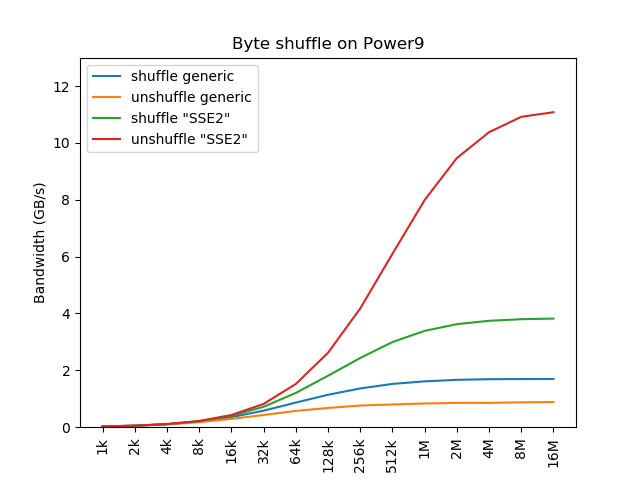

In [20]:
#Old plot to keep !
#fig,ax = subplots()
#ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
#ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
#ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle "SSE2"')
#ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "SSE2"')
#ax.legend()
#ax.set_title("Byte shuffle on Power9")
#ax.set_ylabel("Bandwidth (GB/s)")
#ax.set_ylim((0, 13))
#ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
#ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')#
#
#fig.savefig("shuffle.svg", transparent=True)

<IPython.core.display.Javascript object>


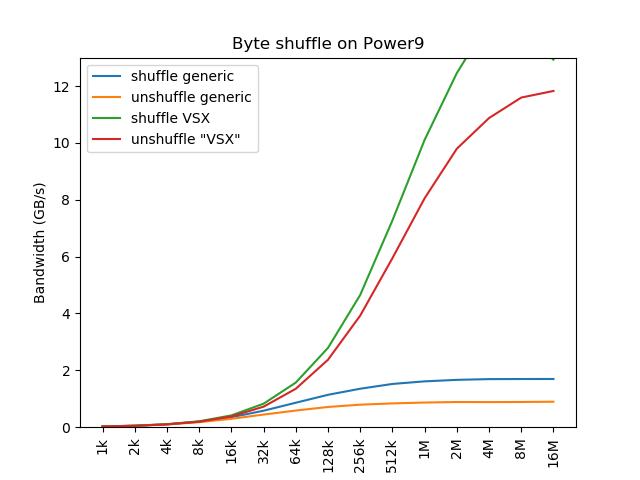

[Text(0, 0, '1k'),
 Text(0, 0, '2k'),
 Text(0, 0, '4k'),
 Text(0, 0, '8k'),
 Text(0, 0, '16k'),
 Text(0, 0, '32k'),
 Text(0, 0, '64k'),
 Text(0, 0, '128k'),
 Text(0, 0, '256k'),
 Text(0, 0, '512k'),
 Text(0, 0, '1M'),
 Text(0, 0, '2M'),
 Text(0, 0, '4M'),
 Text(0, 0, '8M'),
 Text(0, 0, '16M')]

In [10]:
fig,ax = subplots()
ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle VSX')
ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "VSX"')
ax.legend()
ax.set_title("Byte shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_ylim((0, 13))
ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')

#fig.savefig("shuffle.svg", transparent=True)

In [10]:
results_shuffle_generic = benchmark("shuffle_generic", "unshuffle_generic", maxsize=25, dtype="int16")
results_shuffle_sse2 = benchmark("shuffle_altivec", "unshuffle_altivec", maxsize=25, dtype="int16")
fig,ax = subplots()
ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle VSX')
ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "VSX"')
ax.legend()
ax.set_title("Byte shuffle on Power9 using int16")
ax.set_ylabel("Bandwidth (GB/s)")
#ax.set_ylim((0, 13))
ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')

Benchmarking shuffle_generic and unshuffle_generic
1k 1024
10000 loops, best of 5: 37.6 µs per loop
10000 loops, best of 5: 37.3 µs per loop
2k 2048
10000 loops, best of 5: 37.9 µs per loop
10000 loops, best of 5: 38.4 µs per loop
4k 4096
10000 loops, best of 5: 39.1 µs per loop
10000 loops, best of 5: 39.9 µs per loop
8k 8192
10000 loops, best of 5: 41.6 µs per loop
The slowest run took 6.70 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 43.4 µs per loop
16k 16384
The slowest run took 6.71 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 46.4 µs per loop
10000 loops, best of 5: 50.2 µs per loop
32k 32768
The slowest run took 5.47 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 56.2 µs per loop
The slowest run took 4.57 times longer than the fastest. This could mean that an intermediat

<IPython.core.display.Javascript object>

[Text(0, 0, '1k'),
 Text(0, 0, '2k'),
 Text(0, 0, '4k'),
 Text(0, 0, '8k'),
 Text(0, 0, '16k'),
 Text(0, 0, '32k'),
 Text(0, 0, '64k'),
 Text(0, 0, '128k'),
 Text(0, 0, '256k'),
 Text(0, 0, '512k'),
 Text(0, 0, '1M'),
 Text(0, 0, '2M'),
 Text(0, 0, '4M'),
 Text(0, 0, '8M'),
 Text(0, 0, '16M')]

<IPython.core.display.Javascript object>


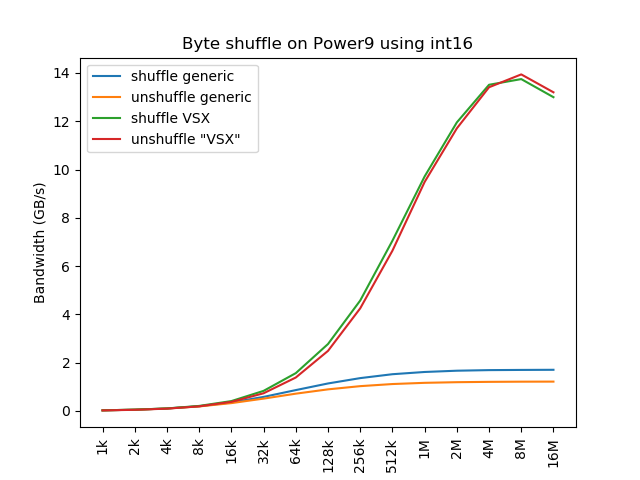

[Text(0, 0, '1k'),
 Text(0, 0, '2k'),
 Text(0, 0, '4k'),
 Text(0, 0, '8k'),
 Text(0, 0, '16k'),
 Text(0, 0, '32k'),
 Text(0, 0, '64k'),
 Text(0, 0, '128k'),
 Text(0, 0, '256k'),
 Text(0, 0, '512k'),
 Text(0, 0, '1M'),
 Text(0, 0, '2M'),
 Text(0, 0, '4M'),
 Text(0, 0, '8M'),
 Text(0, 0, '16M')]

In [12]:
fig,ax = subplots()
ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle VSX')
ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "VSX"')
ax.legend()
ax.set_title("Byte shuffle on Power9 using int16")
ax.set_ylabel("Bandwidth (GB/s)")
#ax.set_ylim((0, 13))
ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')

Benchmarking shuffle_generic and unshuffle_generic
1k 1024
10000 loops, best of 5: 38.9 µs per loop
10000 loops, best of 5: 37.5 µs per loop
2k 2048
10000 loops, best of 5: 37.7 µs per loop
10000 loops, best of 5: 38.8 µs per loop
4k 4096
10000 loops, best of 5: 38.9 µs per loop
The slowest run took 7.07 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 41.2 µs per loop
8k 8192
The slowest run took 6.43 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 41.4 µs per loop
The slowest run took 6.37 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 45.8 µs per loop
16k 16384
The slowest run took 5.69 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 46.3 µs per loop
The slowest run took 5.32 times longer than the fastest. This coul

<IPython.core.display.Javascript object>


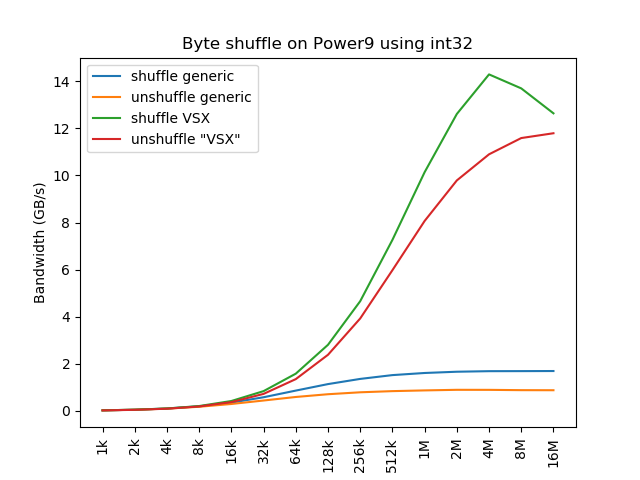

[Text(0, 0, '1k'),
 Text(0, 0, '2k'),
 Text(0, 0, '4k'),
 Text(0, 0, '8k'),
 Text(0, 0, '16k'),
 Text(0, 0, '32k'),
 Text(0, 0, '64k'),
 Text(0, 0, '128k'),
 Text(0, 0, '256k'),
 Text(0, 0, '512k'),
 Text(0, 0, '1M'),
 Text(0, 0, '2M'),
 Text(0, 0, '4M'),
 Text(0, 0, '8M'),
 Text(0, 0, '16M')]

In [13]:
results_shuffle_generic = benchmark("shuffle_generic", "unshuffle_generic", maxsize=25, dtype="int32")
results_shuffle_sse2 = benchmark("shuffle_altivec", "unshuffle_altivec", maxsize=25, dtype="int32")
fig,ax = subplots()
ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle VSX')
ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "VSX"')
ax.legend()
ax.set_title("Byte shuffle on Power9 using int32")
ax.set_ylabel("Bandwidth (GB/s)")
#ax.set_ylim((0, 13))
ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')

In [ ]:
results_shuffle_generic = benchmark("shuffle_generic", "unshuffle_generic", maxsize=25, dtype="int64")
results_shuffle_sse2 = benchmark("shuffle_altivec", "unshuffle_altivec", maxsize=25, dtype="int64")
fig,ax = subplots()
ax.plot([i.flux for i in results_shuffle_generic.values()], label="shuffle generic")
ax.plot([i.reflux for i in results_shuffle_generic.values()], label="unshuffle generic")
ax.plot([i.flux for i in results_shuffle_sse2.values()], label='shuffle VSX')
ax.plot([i.reflux for i in results_shuffle_sse2.values()], label='unshuffle "VSX"')
ax.legend()
ax.set_title("Byte shuffle on Power9 using int64")
ax.set_ylabel("Bandwidth (GB/s)")
#ax.set_ylim((0, 13))
ax.set_xticks(numpy.arange(len(results_shuffle_sse2)))
ax.set_xticklabels(list(results_shuffle_sse2.keys()), rotation='vertical')

In [12]:
def benchmark_bit(sflux="bshuf_trans_bit_elem_scal", sreflux= "bshuf_untrans_bit_elem_scal", 
                  dtype="int32", minsize=10, maxsize=25):
    print("Benchmarking bitshuffle %s and %s"%(sflux, sflux))
    flux = blosc2.__getattr__(sflux)
    reflux = blosc2.__getattr__(sreflux)
    type_size = c_int32(numpy.dtype(dtype).itemsize)
    globals()["flux"] = flux
    globals()["reflux"] = reflux
    globals()["type_size"] = type_size
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        inp = numpy.random.randint(1<<31, size=size//4).astype(dtype)
        tmp = numpy.empty_like(inp)
        temp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        
        blocksize = c_int32(inp.size)
        flux(inp.ctypes.data, tmp.ctypes.data,blocksize, type_size, temp.ctypes.data)
        reflux(tmp.ctypes.data, out.ctypes.data, blocksize, type_size, temp.ctypes.data)
        assert abs(out-inp).sum() == 0
        
        globals()["blocksize"] = blocksize
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["temp"] = temp
        globals()["out"] = out
        
        b = %timeit -o flux(inp.ctypes.data, tmp.ctypes.data, blocksize, type_size, temp.ctypes.data)
        u = %timeit -o reflux(tmp.ctypes.data, out.ctypes.data, blocksize, type_size, temp.ctypes.data)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [17]:
results_bitshuffle_generic = benchmark_bit("bshuf_trans_bit_elem_scal", "bshuf_untrans_bit_elem_scal")
results_bitshuffle_sse2 = benchmark_bit("bshuf_trans_bit_elem_altivec", "bshuf_untrans_bit_elem_altivec")

Benchmarking bitshuffle bshuf_trans_bit_elem_scal and bshuf_trans_bit_elem_scal
1k 1024
10000 loops, best of 5: 57.5 µs per loop
10000 loops, best of 5: 55.5 µs per loop
2k 2048
10000 loops, best of 5: 57.4 µs per loop
10000 loops, best of 5: 56.5 µs per loop
4k 4096
10000 loops, best of 5: 59.5 µs per loop
The slowest run took 5.55 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 59.1 µs per loop
8k 8192
The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 64.6 µs per loop
10000 loops, best of 5: 64.1 µs per loop
16k 16384
10000 loops, best of 5: 74.9 µs per loop
The slowest run took 4.61 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 73.9 µs per loop
32k 32768
10000 loops, best of 5: 95.5 µs per loop
10000 loops, best of 5: 93.7 µs per loop
64k 65536
10000 loops,

<IPython.core.display.Javascript object>


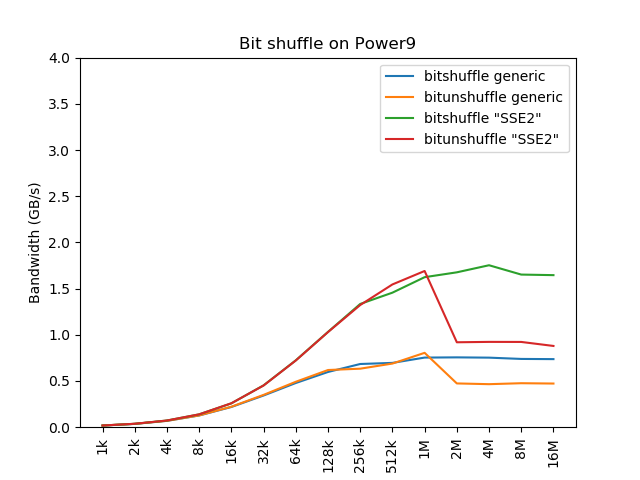

In [19]:
fig,ax = subplots()
ax.plot([i.flux for i in results_bitshuffle_generic.values()], label="bitshuffle generic")
ax.plot([i.reflux for i in results_bitshuffle_generic.values()], label="bitunshuffle generic")
ax.plot([i.flux for i in results_bitshuffle_sse2.values()], label='bitshuffle "SSE2"')
ax.plot([i.reflux for i in results_bitshuffle_sse2.values()], label='bitunshuffle "SSE2"')
# ax.plot([i.flux for i in results_bitshuffle_avx2.values()], label="bitshuffle AVX2")
# ax.plot([i.reflux for i in results_bitshuffle_avx2.values()], label="bitunshuffle AVX2")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(results_bitshuffle_generic)))
ax.set_xticklabels(list(results_bitshuffle_generic.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle.svg", transparent=True)

In [ ]:
ls


In [ ]:
#!cp shuffle.svg shuffle_p9.svg

In [ ]:
#!cp bitshuffle.svg bitshuffle_p9.svg